# По следам модельного эксперимента

$n=20, \quad m=200, \quad m_0=150$,

$\mathbf{X}_i \sim \mathcal{N}(0, 1), \quad i=1,\dots,m_0;$

$\mathbf{X}_i \sim \mathcal{N}(1, 1), \quad i=m_0+1,\dots,m;$

$\mathbf{X}_i \in \mathbb{R}^n.$

**Гипотезы:**

$H^i_0: \mathsf{E}\mathbf{X}_i = 0$;

$H^i_1: \mathsf{E}\mathbf{X}_i \neq 0$;

Пусть $R$ - количество отвергнутых гипотез, а $V$ - количество неверно отвергнутых гипотез

Тогда $FDR \approx {{V} \over {max(R,1)}}$ 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sns
import pandas as pd
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
from numpy.polynomial.polynomial import polyfit


### Функция, считающая $FDR$

In [6]:
m = 200
m0 = 150
n = 20
alpha=0.05

# def FDR(TP, FN, FP, TN):
#     V = FN
#     R = FN + TN
#     FDR = V / (max(R, 1))
#     return FDR

def get_FDR(m=m, m0=m0, n=n, alpha=alpha, method=None):

    rs = np.random.RandomState(68)

    X = rs.randn(m,n)
    X[m0:]+=1
    
    p_values = [st.ttest_1samp(x, 0)[1] for x in X]
    if method:
        rejections = multipletests(p_values, method=method, alpha=alpha)[0]
    else: 
        rejections = multipletests(p_values, alpha=alpha)[0]
        
    FN = sum(rejections[:m0])
    TP = m0 - FN
    TN = sum(rejections[m0:])
    FP = m - m0 - TN
    
    V = FN
    R = FN + TN
    FDR = V / (max(R, 1))
    
    print('{:.2}'.format(FDR), TP, FP, TN, FN)
    
    return FDR

### Зависимость $FDR$ от $m$

FDR TP FP TN FN
0.042 148 4 46 2
0.028 446 13 137 4
0.033 742 18 232 8
0.03 2228 47 703 22
0.035 3708 78 1172 42
0.034 5191 96 1654 59
0.038 6667 121 2129 83
0.04 8144 179 2571 106
0.038 9628 190 3060 122
0.04 11101 193 3557 149
0.039 12587 224 4026 163
0.039 14067 274 4476 183
0.039 14810 284 4716 190
0.037 29642 555 9445 358
0.036 44469 852 14148 531
0.036 59290 1120 18880 710


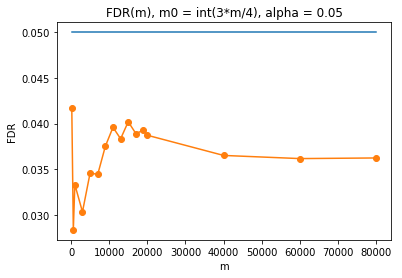

In [7]:
ms = list(np.arange(200, 1000, 400)) + list(np.arange(1000, 20000, 2000)) + list(np.arange(20000, 100000, 20000))
print('FDR TP FP TN FN')
FDRS_m = [get_FDR(m=m, m0 = int(3*m/4), method = 'fdr_bh') for m in ms]

plt.plot(ms, [0.05]*len(ms))
plt.plot(ms, FDRS_m, 'o-')

plt.title('FDR(m), m0 = int(3*m/4), alpha = 0.05')
plt.ylabel('FDR')
plt.xlabel('m')
plt.show()

In [16]:
np.mean(FDRS_m[-5:])

0.037388688698843285

*Вывод*: Зависимость $FDR$ от $m$ не наблюдается. Возможно, имеется сходимость к некоторому значению, но это не точно.
А именно, к $m_0 / m * \alpha = 3/4*0.05=0.0375$

### Зависимость $FDR$ от $m_0$

FDR TP FP TN FN
0.00051 95 126 9774 5
0.0028 595 127 9252 26
0.0054 1095 125 8733 47
0.0082 1595 128 8209 68
0.011 2096 125 7691 88
0.014 2603 131 7164 102
0.017 3114 134 6640 112
0.019 3629 135 6118 118
0.021 4148 139 5593 120
0.023 4671 143 5068 118
0.026 5189 138 4552 121
0.028 5717 140 4029 114
0.031 6239 145 3503 113
0.033 6771 147 2980 102
0.039 7294 148 2458 100
0.042 7831 148 1937 84
0.039 8379 144 1420 57
0.04 8919 131 912 38
0.051 9455 92 430 23
0.0 10000 0 0 0


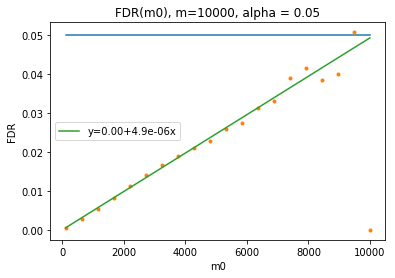

In [8]:
m0s = np.linspace(100, 10000, 20)
print('FDR TP FP TN FN')
FDRS_m0 = [get_FDR(m=10000, m0=int(m0), method = 'fdr_bh') for m0 in m0s]

plt.plot(m0s, [0.05]*len(m0s))
plt.plot(m0s, FDRS_m0, '.')

# Fit with polyfit
b, k = polyfit(m0s[:-1], FDRS_m0[:-1], 1)
plt.plot(m0s, b+k * m0s, '-', label='y={:.2f}+{:.2}x'.format(b,k))

plt.ylabel('FDR')
plt.xlabel('m0')
plt.title('FDR(m0), m=10000, alpha = 0.05')
plt.legend()
plt.show()

Последняя точка внизу - случай, когда $m=m0=10000$. То есть нет неверных нулевых гипотез. Все значения $p-{value}$ получаются высокими и ни одна гипотеза не отвергается, поэтому $V=R=0$

In [9]:
import scipy.stats as st
st.pearsonr(m0s, FDRS_m0)

(0.7285067148851128, 0.0002698542674862204)

In [10]:
st.pearsonr(m0s[:-1], FDRS_m0[:-1]) # без выбросов

(0.9920342429629458, 9.725027323548167e-17)

*Вывод*: Наблюдается линейная зависимость $FDR$ от $m_0$. Гипотеза об отсутствии корреляции уверенно отвергается

### Зависимость $FDR$ от $alpha$

FDR TP FP TN FN
0.0011 7499 1551 949 1
0.011 7477 475 2025 23
0.016 7464 291 2209 36
0.024 7444 213 2287 56
0.034 7419 169 2331 81
0.042 7397 140 2360 103
0.048 7380 114 2386 120
0.055 7359 96 2404 141
0.064 7334 82 2418 166
0.074 7307 71 2429 193
0.082 7283 60 2440 217
0.09 7257 53 2447 243
0.1 7226 47 2453 274
0.11 7201 38 2462 299
0.12 7170 36 2464 330
0.12 7151 31 2469 349
0.13 7130 28 2472 370
0.14 7098 25 2475 402
0.15 7057 22 2478 443
0.16 7029 19 2481 471


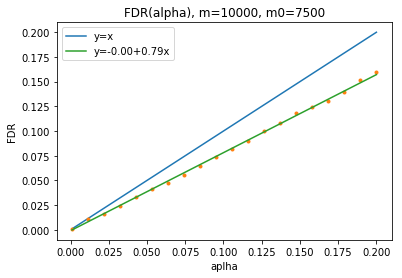

In [11]:
alphas = np.linspace(0.001, 0.2, 20)
print('FDR TP FP TN FN')
FDRS_alpha = [get_FDR(m=10000, m0=7500, method = 'fdr_bh', alpha=alpha) for alpha in alphas]

plt.plot(alphas, alphas, label='y=x')
plt.plot(alphas, FDRS_alpha, '.')

# Fit with polyfit
b, k = polyfit(alphas[:-1], FDRS_alpha[:-1], 1)
plt.plot(alphas, b+k * alphas, '-', label='y={:.2f}+{:.2}x'.format(b,k))

plt.xlabel('aplha')
plt.ylabel('FDR')
plt.title('FDR(alpha), m=10000, m0=7500')
plt.legend()
plt.show()

In [12]:
st.pearsonr(alphas, FDRS_alpha)

(0.999434271816521, 5.625106253413389e-28)

*Вывод*: Аналогично предыдущему пункту, наблюдается линейная зависимость $FDR$ от $alpha$. Гипотеза об отсутствии корреляции уверенно отвергается. Результаты согласуются с теорией.